In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import gower

output_file_path = '../2_joined_data/2017_2024_GSM_j_s_clustered_4.csv'
# 2017_2024_GSM_j_s_clustered.csv'

joined_file_path = '../2_joined_data/2017_2024_GSM_j_scaled.csv'
df = pd.read_csv(joined_file_path, delimiter=",", header="infer")

# Select features for clustering, including categorical columns
features = ["weight_g_scale", "display_size_inches_scale", "battery_mah_scale"]
X = df[features].dropna()

# Compute the Gower distance matrix
gower_dist = gower.gower_matrix(X)

# Step 2: Preprocess the Data (Scale the Features)
clustering = AgglomerativeClustering(
    n_clusters=4,               # Adjust the number of clusters as needed
    metric='precomputed',     # Use precomputed distance matrix
    linkage='average'           # 'average', 'complete', or 'single' linkage
)

labels = clustering.fit_predict(gower_dist)

# Assign cluster labels to your DataFrame
df.loc[X.index, 'cluster'] = labels

df.to_csv(output_file_path, sep=',', index=False)

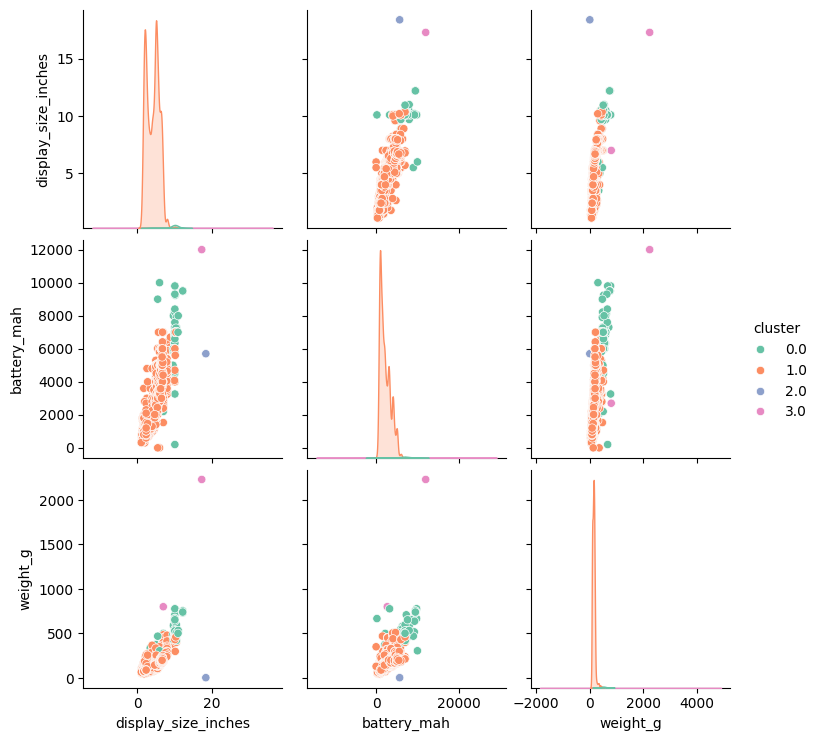

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'cluster' column is of integer type
df['cluster'] = df['cluster'].astype('Int64')

# Select the features you used for clustering
features = ["display_size_inches", "battery_mah", "weight_g"]

# Create a pairplot with clusters colored
sns.pairplot(df, vars=features, hue='cluster', palette='Set2', diag_kind='kde')
plt.show()


In [7]:
# Filter rows based on column: 'cluster'
df_jsc = df[(df['cluster'] == 1)]

# Dropping obvious non-phones like tablets and watches
keywords = ["tablet", "watch", "ipad", "pad"]
df_jsc.drop(df_jsc.loc[df_jsc['id'].str.contains("|".join(keywords), case=False, na=False)].index, inplace=True)
# Drop scaled columns
df_jsc.drop(columns=[col for col in df.columns if 'scale' in col], inplace=True)

output_file_path = '../2_joined_data/2017_2024_GSM_jsc.csv'
df_jsc.to_csv(output_file_path, sep=',', index=False)

C:\Users\meike\AppData\Local\Temp\ipykernel_27832\1286477890.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jsc.drop(df_jsc.loc[df_jsc['id'].str.contains("|".join(keywords), case=False, na=False)].index, inplace=True)
C:\Users\meike\AppData\Local\Temp\ipykernel_27832\1286477890.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jsc.drop(columns=[col for col in df.columns if 'scale' in col], inplace=True)


In [8]:
# scale data without tablets
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the CSV into a DataFrame
file_path = '../2_joined_data/2017_2024_GSM_jsc.csv'
df = pd.read_csv(file_path)
# df = merged_df.copy(deep=True)

scaled_file_path = '../2_joined_data/2017_2024_GSM_jsc_scaled.csv'

# Identify numerical columns, excluding 'year'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols[numerical_cols != 'year']

print("scaling columns: ", list(numerical_cols))
# Apply scaling within each group while retaining original columns
group_col = 'year'

def scale_group(group):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group[numerical_cols])
    scaled_cols = [col + '_scale' for col in numerical_cols]
    scaled_df = pd.DataFrame(scaled_data, columns=scaled_cols, index=group.index)
    for orig_col, scaled_col in zip(numerical_cols, scaled_cols):
        # Insert scaled columns right after the original columns
        col_idx = group.columns.get_loc(orig_col)
        group.insert(col_idx + 1, scaled_col, scaled_df[scaled_col])
    return group

# Apply scaling to each group by the specified column (e.g., 'year')
df = df.groupby(group_col, group_keys=False).apply(scale_group)
df = df.sort_values(['year', 'id'])

# Save the final DataFrame to a CSV file
df.to_csv(scaled_file_path, index=False)

print(len(df))
print(f"Grouped scaled data saved to {scaled_file_path}")

c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\dev\python\phoneData\.bda\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: inva

scaling columns:  ['display_size_inches', 'internal_memory_in_gb', 'primary_camera_mega_pixel', 'approx_price_eur', 'battery_mah', 'ram_in_gb', 'weight_g', 'cluster']


C:\Users\meike\AppData\Local\Temp\ipykernel_27832\166441972.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_col, group_keys=False).apply(scale_group)


7204
Grouped scaled data saved to ../2_joined_data/2017_2024_GSM_jsc_scaled.csv


In [ ]:
# figure out which models only appear whith scaling and without

import pandas as pd

# Example DataFrames
scaled_file_path = '../2_joined_data/2017_2024_GSM_j_s_clustered_4.csv'
scaled_df = pd.read_csv(scaled_file_path, delimiter=",", header="infer")

unscaled_file_path = '../2_joined_data/2017_2024_GSM_j_clustered_4.csv'
unscaled_df = pd.read_csv(unscaled_file_path, delimiter=",", header="infer")

# Get keys from both DataFrames as sets
ids_scaled_df = set(scaled_df['id'])
ids_unscaled_df = set(unscaled_df['id'])

# Identify keys only in df1, only in df2, or in both
only_in_scaled_df = ids_scaled_df - ids_unscaled_df
only_in_unscaled_df = ids_unscaled_df - ids_scaled_df
in_both = ids_scaled_df & ids_unscaled_df

# Display the results
print("IDs only in scaled_df:", only_in_scaled_df)
print("IDs only in unscaled_df:", only_in_unscaled_df)
print("IDs in both:", in_both)